#Accuracy : 88.76%


In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from skimage import transform
import numpy as np
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os as os
from google.colab import files
import skimage

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 12
num_filter = 64
compression = 1
dropout_rate = 0.2

In [5]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

X_train = []
X_test = []
for i in range(0, x_train.shape[0]):
  X_train.append(skimage.transform.resize(x_train[i],(24,24)))

X_train = np.asarray(X_train)   
  
for i in range(0, x_test.shape[0]):
  X_test.append(skimage.transform.resize(x_test[i],(24,24)))

X_test = np.asarray(X_test)  

img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, channel)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, channel)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 24s 0us/step


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
       
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
       
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
   
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False, padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)
  
Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 24, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

NameError: ignored

In [0]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=4, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)
logger = CSVLogger(os.path.join("LogFile.log"))
callbacks_list = [reduce_lr, checkpoint, logger]

In [15]:
model_info_24x24 = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_test, y_test), 
                    callbacks = callbacks_list,
                    shuffle='True')

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
43712/50000 [=========================>....] - ETA: 1:14 - loss: 1.5558 - acc: 0.4235

50000/50000 [==============================] - 635s 13ms/step - loss: 1.5096 - acc: 0.4415 - val_loss: 3.2065 - val_acc: 0.3073

Epoch 00001: val_acc improved from -inf to 0.30730, saving model to weights.best.hdf5
Epoch 2/15
18688/50000 [==========>...................] - ETA: 6:01 - loss: 1.0828 - acc: 0.6083

50000/50000 [==============================] - 618s 12ms/step - loss: 0.9904 - acc: 0.6457 - val_loss: 2.0464 - val_acc: 0.5146

Epoch 00002: val_acc improved from 0.30730 to 0.51460, saving model to weights.best.hdf5
Epoch 3/15
11776/50000 [======>.......................] - ETA: 7:18 - loss: 0.8398 - acc: 0.7018

50000/50000 [==============================] - 617s 12ms/step - loss: 0.7785 - acc: 0.7269 - val_loss: 1.6687 - val_acc: 0.5520

Epoch 00003: val_acc improved from 0.51460 to 0.55200, saving model to weights.best.hdf5
Epoch 4/15
 9920/50000 [====>.........................] - ETA: 7:42 - loss: 0.6781 - acc: 0.7629

50000/50000 [==============================] - 619s 12ms/step - loss: 0.6562 - acc: 0.7699 - val_loss: 1.9972 - val_acc: 0.5654

Epoch 00004: val_acc improved from 0.55200 to 0.56540, saving model to weights.best.hdf5
Epoch 5/15
 9408/50000 [====>.........................] - ETA: 7:48 - loss: 0.5749 - acc: 0.8020

50000/50000 [==============================] - 616s 12ms/step - loss: 0.5695 - acc: 0.8031 - val_loss: 1.6284 - val_acc: 0.5882

Epoch 00005: val_acc improved from 0.56540 to 0.58820, saving model to weights.best.hdf5
Epoch 6/15
 9280/50000 [====>.........................] - ETA: 7:46 - loss: 0.5094 - acc: 0.8192

50000/50000 [==============================] - 617s 12ms/step - loss: 0.5047 - acc: 0.8235 - val_loss: 1.2953 - val_acc: 0.6692

Epoch 00006: val_acc improved from 0.58820 to 0.66920, saving model to weights.best.hdf5
Epoch 7/15
 9216/50000 [====>.........................] - ETA: 7:50 - loss: 0.4430 - acc: 0.8462

50000/50000 [==============================] - 620s 12ms/step - loss: 0.4456 - acc: 0.8457 - val_loss: 0.8623 - val_acc: 0.7410

Epoch 00007: val_acc improved from 0.66920 to 0.74100, saving model to weights.best.hdf5
Epoch 8/15
 9216/50000 [====>.........................] - ETA: 7:51 - loss: 0.4147 - acc: 0.8516

50000/50000 [==============================] - 619s 12ms/step - loss: 0.4025 - acc: 0.8590 - val_loss: 1.6534 - val_acc: 0.6573

Epoch 00008: val_acc did not improve from 0.74100
Epoch 9/15
10560/50000 [=====>........................] - ETA: 7:35 - loss: 0.3445 - acc: 0.8808

50000/50000 [==============================] - 620s 12ms/step - loss: 0.3567 - acc: 0.8754 - val_loss: 0.8162 - val_acc: 0.7703

Epoch 00009: val_acc improved from 0.74100 to 0.77030, saving model to weights.best.hdf5
Epoch 10/15
 9536/50000 [====>.........................] - ETA: 7:47 - loss: 0.3102 - acc: 0.8930

50000/50000 [==============================] - 618s 12ms/step - loss: 0.3202 - acc: 0.8900 - val_loss: 0.8339 - val_acc: 0.7799

Epoch 00010: val_acc improved from 0.77030 to 0.77990, saving model to weights.best.hdf5
Epoch 11/15
 9280/50000 [====>.........................] - ETA: 7:46 - loss: 0.2824 - acc: 0.9024

50000/50000 [==============================] - 614s 12ms/step - loss: 0.2884 - acc: 0.8991 - val_loss: 1.2962 - val_acc: 0.7168

Epoch 00011: val_acc did not improve from 0.77990
Epoch 12/15
10560/50000 [=====>........................] - ETA: 7:32 - loss: 0.2427 - acc: 0.9145

50000/50000 [==============================] - 614s 12ms/step - loss: 0.2588 - acc: 0.9079 - val_loss: 1.0257 - val_acc: 0.7583

Epoch 00012: val_acc did not improve from 0.77990
Epoch 13/15
10944/50000 [=====>........................] - ETA: 7:26 - loss: 0.2136 - acc: 0.9238

50000/50000 [==============================] - 614s 12ms/step - loss: 0.2292 - acc: 0.9188 - val_loss: 0.9663 - val_acc: 0.7651

Epoch 00013: val_acc did not improve from 0.77990
Epoch 14/15
11072/50000 [=====>........................] - ETA: 7:24 - loss: 0.1498 - acc: 0.9491

50000/50000 [==============================] - 614s 12ms/step - loss: 0.1237 - acc: 0.9584 - val_loss: 0.5323 - val_acc: 0.8665

Epoch 00014: val_acc improved from 0.77990 to 0.86650, saving model to weights.best.hdf5
Epoch 15/15
 9664/50000 [====>.........................] - ETA: 7:42 - loss: 0.0953 - acc: 0.9684

50000/50000 [==============================] - 615s 12ms/step - loss: 0.0950 - acc: 0.9681 - val_loss: 0.5767 - val_acc: 0.8622

Epoch 00015: val_acc did not improve from 0.86650


In [16]:
#Last two layers (Flatten and FC) removed from 24x24 model
model.layers.pop()
model.layers.pop()
model.summary()
model.save_weights("DNST_model_24x24.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 24, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
files.download('DNST_model_24x24.h5')
files.download('LogFile.log')

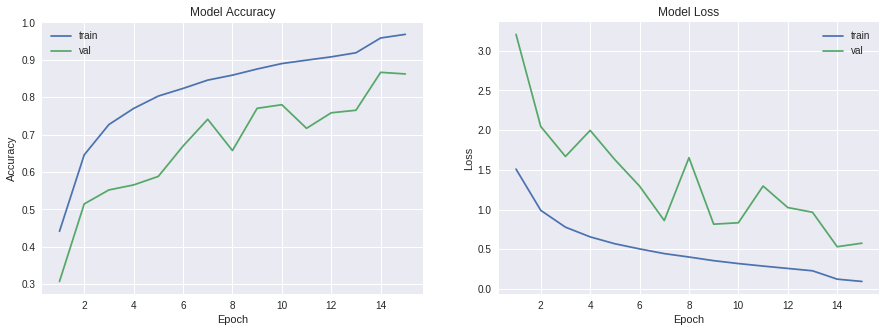

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(model_info_24x24)    

In [0]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

x_train = x_train.reshape(x_train.shape[0], img_height, img_width, channel)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, channel)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # Normalise data to [0, 1] range
x_test /= 255 # Normalise data to [0, 1] range

input1 = Input(shape=(img_height, img_width, channel,))

First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False)(input1)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)
  
Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
BatchNorm = BatchNormalization()(Last_Block)
relu = Activation('relu')(BatchNorm)
AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)


In [10]:
from google.colab import files
uploaded = files.upload()

Saving DNST_model_24x24.h5 to DNST_model_24x24.h5


In [12]:
model1 = Model(inputs=[input1], outputs=[AvgPooling])
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 30, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 30, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
#Loading weights from 24x24 model
model1.load_weights('DNST_model_24x24.h5')


In [0]:
# Adding the last two layers to create a connected model

#connecting_input = model_32x32.layers[-1].output
flat = Flatten()(model1.output)
output = Dense(num_classes, activation='softmax')(flat)

model1 = Model(inputs=[model1.input],outputs=[output])

In [0]:
# determine Loss function and Optimizer
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [16]:
# checkpoint
filepath="weights.best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
logger = CSVLogger(os.path.join("LogFile2.log"))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=3, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)
callbacks_list1 = [reduce_lr, checkpoint, logger]

model_info_32x32 = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    verbose=1,
                    validation_data=(x_test, y_test), 
                    callbacks = callbacks_list1,
                    shuffle='True')

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
43648/50000 [=========================>....] - ETA: 1:45 - loss: 0.3975 - acc: 0.8649

50000/50000 [==============================] - 894s 18ms/step - loss: 0.3883 - acc: 0.8678 - val_loss: 1.0849 - val_acc: 0.7468

Epoch 00001: val_acc improved from -inf to 0.74680, saving model to weights.best2.hdf5
Epoch 2/35
18560/50000 [==========>...................] - ETA: 8:29 - loss: 0.2477 - acc: 0.9135

50000/50000 [==============================] - 875s 17ms/step - loss: 0.2596 - acc: 0.9082 - val_loss: 0.5288 - val_acc: 0.8440

Epoch 00002: val_acc improved from 0.74680 to 0.84400, saving model to weights.best2.hdf5
Epoch 3/35
11648/50000 [=====>........................] - ETA: 10:21 - loss: 0.2002 - acc: 0.9288

50000/50000 [==============================] - 875s 17ms/step - loss: 0.2114 - acc: 0.9258 - val_loss: 0.5679 - val_acc: 0.8484

Epoch 00003: val_acc improved from 0.84400 to 0.84840, saving model to weights.best2.hdf5
Epoch 4/35
 9792/50000 [====>.........................] - ETA: 10:50 - loss: 0.1630 - acc: 0.9439

50000/50000 [==============================] - 874s 17ms/step - loss: 0.1801 - acc: 0.9369 - val_loss: 0.6194 - val_acc: 0.8400

Epoch 00004: val_acc did not improve from 0.84840
Epoch 5/35
10688/50000 [=====>........................] - ETA: 10:35 - loss: 0.1445 - acc: 0.9483

50000/50000 [==============================] - 874s 17ms/step - loss: 0.1535 - acc: 0.9455 - val_loss: 0.5399 - val_acc: 0.8578

Epoch 00005: val_acc improved from 0.84840 to 0.85780, saving model to weights.best2.hdf5
Epoch 6/35
 9536/50000 [====>.........................] - ETA: 10:54 - loss: 0.0980 - acc: 0.9651

50000/50000 [==============================] - 874s 17ms/step - loss: 0.0752 - acc: 0.9745 - val_loss: 0.4080 - val_acc: 0.8990

Epoch 00006: val_acc improved from 0.85780 to 0.89900, saving model to weights.best2.hdf5
Epoch 7/35
 9216/50000 [====>.........................] - ETA: 11:00 - loss: 0.0529 - acc: 0.9826

50000/50000 [==============================] - 874s 17ms/step - loss: 0.0508 - acc: 0.9827 - val_loss: 0.4318 - val_acc: 0.8998

Epoch 00007: val_acc improved from 0.89900 to 0.89980, saving model to weights.best2.hdf5
Epoch 8/35
 9152/50000 [====>.........................] - ETA: 10:58 - loss: 0.0410 - acc: 0.9851

50000/50000 [==============================] - 872s 17ms/step - loss: 0.0397 - acc: 0.9863 - val_loss: 0.4412 - val_acc: 0.9013

Epoch 00008: val_acc improved from 0.89980 to 0.90130, saving model to weights.best2.hdf5
Epoch 9/35
 9088/50000 [====>.........................] - ETA: 11:00 - loss: 0.0355 - acc: 0.9878

50000/50000 [==============================] - 872s 17ms/step - loss: 0.0350 - acc: 0.9879 - val_loss: 0.4551 - val_acc: 0.9012

Epoch 00009: val_acc did not improve from 0.90130
Epoch 10/35
10432/50000 [=====>........................] - ETA: 10:38 - loss: 0.0304 - acc: 0.9893

50000/50000 [==============================] - 872s 17ms/step - loss: 0.0267 - acc: 0.9913 - val_loss: 0.4650 - val_acc: 0.9020

Epoch 00010: val_acc improved from 0.90130 to 0.90200, saving model to weights.best2.hdf5
Epoch 11/35
 9408/50000 [====>.........................] - ETA: 10:55 - loss: 0.0260 - acc: 0.9904

50000/50000 [==============================] - 871s 17ms/step - loss: 0.0246 - acc: 0.9925 - val_loss: 0.4689 - val_acc: 0.9015

Epoch 00011: val_acc did not improve from 0.90200
Epoch 12/35
10560/50000 [=====>........................] - ETA: 10:34 - loss: 0.0228 - acc: 0.9930

50000/50000 [==============================] - 871s 17ms/step - loss: 0.0230 - acc: 0.9931 - val_loss: 0.4690 - val_acc: 0.9014

Epoch 00012: val_acc did not improve from 0.90200
Epoch 13/35
10880/50000 [=====>........................] - ETA: 10:29 - loss: 0.0246 - acc: 0.9916

50000/50000 [==============================] - 869s 17ms/step - loss: 0.0246 - acc: 0.9921 - val_loss: 0.4734 - val_acc: 0.9008

Epoch 00013: val_acc did not improve from 0.90200
Epoch 14/35
11008/50000 [=====>........................] - ETA: 10:27 - loss: 0.0250 - acc: 0.9922

50000/50000 [==============================] - 869s 17ms/step - loss: 0.0236 - acc: 0.9929 - val_loss: 0.4722 - val_acc: 0.9010

Epoch 00014: val_acc did not improve from 0.90200
Epoch 15/35
11008/50000 [=====>........................] - ETA: 10:26 - loss: 0.0231 - acc: 0.9928

50000/50000 [==============================] - 869s 17ms/step - loss: 0.0243 - acc: 0.9916 - val_loss: 0.4746 - val_acc: 0.9007

Epoch 00015: val_acc did not improve from 0.90200
Epoch 16/35
11008/50000 [=====>........................] - ETA: 10:25 - loss: 0.0208 - acc: 0.9930

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0233 - acc: 0.9926 - val_loss: 0.4725 - val_acc: 0.9018

Epoch 00016: val_acc did not improve from 0.90200
Epoch 17/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0215 - acc: 0.9935

50000/50000 [==============================] - 871s 17ms/step - loss: 0.0252 - acc: 0.9920 - val_loss: 0.4719 - val_acc: 0.9016

Epoch 00017: val_acc did not improve from 0.90200
Epoch 18/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0228 - acc: 0.9922

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0227 - acc: 0.9924 - val_loss: 0.4733 - val_acc: 0.9010

Epoch 00018: val_acc did not improve from 0.90200
Epoch 19/35
11008/50000 [=====>........................] - ETA: 10:27 - loss: 0.0261 - acc: 0.9908

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0236 - acc: 0.9924 - val_loss: 0.4705 - val_acc: 0.9015

Epoch 00019: val_acc did not improve from 0.90200
Epoch 20/35
11008/50000 [=====>........................] - ETA: 10:27 - loss: 0.0234 - acc: 0.9923

50000/50000 [==============================] - 868s 17ms/step - loss: 0.0241 - acc: 0.9922 - val_loss: 0.4717 - val_acc: 0.9015

Epoch 00020: val_acc did not improve from 0.90200
Epoch 21/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0230 - acc: 0.9926

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0239 - acc: 0.9924 - val_loss: 0.4719 - val_acc: 0.9018

Epoch 00021: val_acc did not improve from 0.90200
Epoch 22/35
11008/50000 [=====>........................] - ETA: 10:29 - loss: 0.0254 - acc: 0.9920

50000/50000 [==============================] - 871s 17ms/step - loss: 0.0242 - acc: 0.9920 - val_loss: 0.4727 - val_acc: 0.9008

Epoch 00022: val_acc did not improve from 0.90200
Epoch 23/35
11008/50000 [=====>........................] - ETA: 10:29 - loss: 0.0199 - acc: 0.9945

50000/50000 [==============================] - 871s 17ms/step - loss: 0.0224 - acc: 0.9934 - val_loss: 0.4740 - val_acc: 0.9014

Epoch 00023: val_acc did not improve from 0.90200
Epoch 24/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0244 - acc: 0.9920

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0238 - acc: 0.9924 - val_loss: 0.4726 - val_acc: 0.9013

Epoch 00024: val_acc did not improve from 0.90200
Epoch 25/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0230 - acc: 0.9924

50000/50000 [==============================] - 870s 17ms/step - loss: 0.0231 - acc: 0.9926 - val_loss: 0.4735 - val_acc: 0.9009

Epoch 00025: val_acc did not improve from 0.90200
Epoch 26/35
11008/50000 [=====>........................] - ETA: 10:28 - loss: 0.0243 - acc: 0.9922

23936/50000 [=============>................] - ETA: 6:59 - loss: 0.0233 - acc: 0.9929

KeyboardInterrupt: ignored

In [18]:
# Save the trained weights in to .h5 format
model1.save_weights('model_weights32.h5')

files.download('model_weights32.h5')
files.download('LogFile2.log')
files.download('weights.best2.hdf5')



KeyboardInterrupt: ignored

In [0]:
model1.load_weights('weights.best2.hdf5')

In [19]:
# Test the model
score = model1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 72s 7ms/step
Test loss: 0.4710311422465369
Test accuracy: 0.902


In [0]:
plot_model_history(model_info_32x32)